In [3]:
pip install tensorflow


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
pip install keras

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [36]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
print(tf.__version__)

2.12.0


In [37]:
train_dir = Path(r'C:\Users\Admin\Desktop\prodigy\prodigy_task - 5\train')
train_filepaths = list(train_dir.glob('**/*.jpg'))


In [38]:
test_dir =  Path(r'C:\Users\Admin\Desktop\prodigy\prodigy_task - 5\test')
test_filepaths = list(test_dir.glob('**/*.jpg'))

In [39]:
val_dir = Path(r'C:\Users\Admin\Desktop\prodigy\prodigy_task - 5\validation')
val_filepaths = list(test_dir.glob('**/*.jpg'))

In [43]:


def image_processing(filepath):
    # Create a DataFrame with the filepath and the labels of the pictures
    labels = [str(filepath[i]).split("\\")[-2] for i in range(len(filepath))]  # Adjust for backslashes
    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)
    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop=True)
    return df


In [44]:
train_df = image_processing (train_filepaths)
test_df = image_processing (test_filepaths)
val_df = image_processing (val_filepaths)

In [46]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')  # Corrected 'label' to 'Label'
print(f'Labels: {train_df.Label.unique()}')


-- Training set --

Number of pictures: 2855

Number of different labels: 36

Labels: ['lettuce' 'corn' 'cauliflower' 'cucumber' 'garlic' 'lemon' 'raddish'
 'eggplant' 'banana' 'pomegranate' 'onion' 'spinach' 'kiwi' 'watermelon'
 'tomato' 'jalepeno' 'mango' 'paprika' 'soy beans' 'sweetcorn' 'peas'
 'capsicum' 'ginger' 'chilli pepper' 'beetroot' 'turnip' 'grapes'
 'pineapple' 'orange' 'pear' 'potato' 'apple' 'bell pepper' 'sweetpotato'
 'carrot' 'cabbage']


In [49]:
train_df.head()

,Filepath,Label
0,C:\Users\Admin\Desktop\prodigy\prodigy_task - ...,lettuce
1,C:\Users\Admin\Desktop\prodigy\prodigy_task - ...,corn
2,C:\Users\Admin\Desktop\prodigy\prodigy_task - ...,cauliflower
3,C:\Users\Admin\Desktop\prodigy\prodigy_task - ...,cucumber
4,C:\Users\Admin\Desktop\prodigy\prodigy_task - ...,garlic


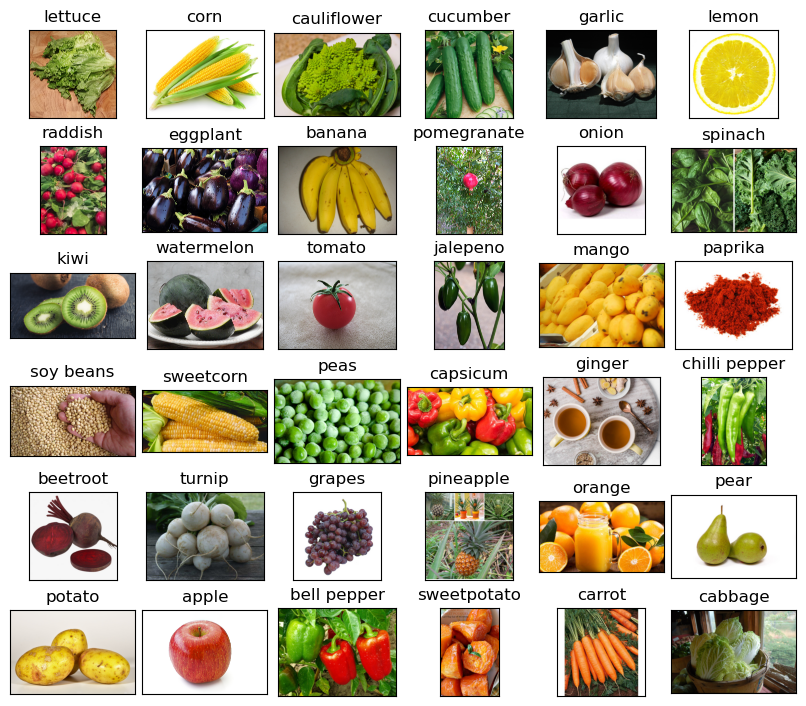

In [53]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize=12)

plt.tight_layout(pad=0.5)
plt.show()


In [54]:
train_generator = tf.keras.preprocessing.image. ImageDataGenerator (
preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)
test_generator = tf.keras.preprocessing.image. ImageDataGenerator (
preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [61]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode="rgb",
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,  # Corrected the assignment operator from "-" to "="
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)


Found 2855 validated image filenames belonging to 36 classes.


In [62]:
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode="rgb",
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,  # Corrected the assignment operator from "-" to "="
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 340 validated image filenames belonging to 36 classes.


In [63]:
test_images = train_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode="rgb",
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    
)

Found 340 validated image filenames belonging to 36 classes.


In [65]:
from keras.applications import MobileNetV2
from keras.layers import GlobalAveragePooling2D

pretrained_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False


9406464/9406464 [==============================] - 20s 2us/step


In [69]:


inputs = pretrained_model.input
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,  # Fixed the typo '-' to '='
    batch_size=32,  # Fixed missing '='
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',  # Fixed the typo '"val_loss"' to 'val_loss'
            patience=2,
            restore_best_weights=True
        )
    ]
)


Epoch 1/5
90/90 [==============================] - 188s 2s/step - loss: 1.7917 - accuracy: 0.5275 - val_loss: 0.4843 - val_accuracy: 0.8588
Epoch 2/5
90/90 [==============================] - 177s 2s/step - loss: 0.5826 - accuracy: 0.8126 - val_loss: 0.2783 - val_accuracy: 0.9176
Epoch 3/5
90/90 [==============================] - 170s 2s/step - loss: 0.3650 - accuracy: 0.8788 - val_loss: 0.2135 - val_accuracy: 0.9471
Epoch 4/5
90/90 [==============================] - 182s 2s/step - loss: 0.2328 - accuracy: 0.9198 - val_loss: 0.1695 - val_accuracy: 0.9500
Epoch 5/5
90/90 [==============================] - 177s 2s/step - loss: 0.1573 - accuracy: 0.9552 - val_loss: 0.1910 - val_accuracy: 0.9353


In [70]:
# Predict the label of the test images
pred = model.predict(test_images) 
pred = np.argmax(pred, axis=1)

# Map the label
labels = train_images.class_indices  
labelset = {v: k for k, v in labels.items()}  
pred1 = [labelset[k] for k in pred]  


11/11 [==============================] - 22s 2s/step


In [72]:



def output(location):
    img = load_img(location, target_size=(224, 224)) 
    img = img_to_array(img)  
    img /= 255.0  
    img = np.expand_dims(img, axis=0)  
    answer = model.predict(img)  
    y_class = answer.argmax(axis=-1)
    y = "".join(str(x) for x in y_class)  
    y = int(y)
    res = labelset[y]  
    return res




In [74]:
img = output(r'C:\Users\Admin\Desktop\prodigy\prodigy_task - 5\test\apple\Image_1.jpg')
img

1/1 [==============================] - 1s 722ms/step


'apple'

In [75]:
model.save('FV.h5')